In [578]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.plotting import plot_lifetimes
from lifelines.statistics import survival_difference_at_fixed_point_in_time_test

plt.style.use('ggplot')

In [579]:
## 2.

customer_churn_data = (
    pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')                            ## reading the data
    .assign(Churn = lambda x: x.Churn.apply(lambda z: True if z == 'Yes' else False))   ## mapping Yes -> True and No -> False
    .loc[:,['SeniorCitizen','Churn','tenure','Dependents','Partner']]
)

customer_churn_data.columns = [x.lower() for x in customer_churn_data.columns]   ## treating column names

customer_churn_data.head()

,seniorcitizen,churn,tenure,dependents,partner
0,0,False,1,No,Yes
1,0,False,34,No,No
2,0,True,2,No,No
3,0,False,45,No,No
4,0,True,2,No,No


In [556]:
## 3. 

data_x, data_y = customer_churn_data.tenure, customer_churn_data.churn  ## our X and y

customer_churn_data[['tenure','churn']].T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7003,7004,7005,7006,7007,7008,7009,7010,7011,7012,7013,7014,7015,7016,7017,7018,7019,7020,7021,7022,7023,7024,7025,7026,7027,7028,7029,7030,7031,7032,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042
tenure,1,34,2,45,2,8,22,10,28,62,13,16,58,49,25,69,52,71,10,21,1,12,1,58,49,30,47,1,72,17,71,2,27,1,1,72,5,46,34,11,...,26,38,23,40,72,3,23,1,4,62,40,41,34,1,51,1,39,12,12,72,63,44,18,9,13,68,6,2,55,1,38,67,19,12,72,24,72,11,4,66
churn,False,False,True,False,True,True,False,False,True,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,False,False,True,True,False,True,False,False,False,False,False,False,True,False,True,True,...,False,False,False,True,False,True,True,True,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False


Text(0.5, 1.0, 'Churn and Not Churn, at $t=25$')

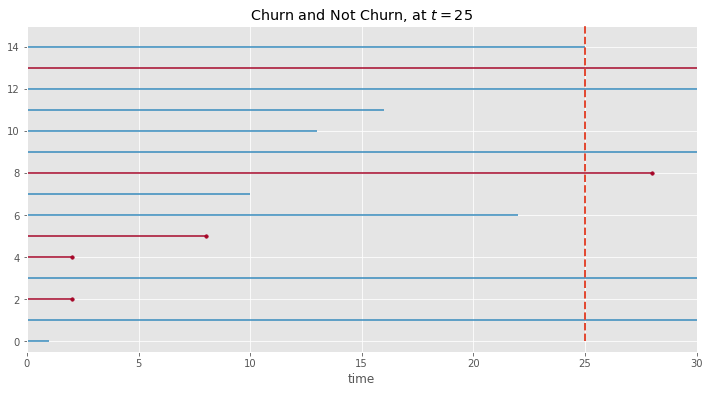

In [557]:
f, ax = plt.subplots(figsize=(12,6))

day_to_plot = 25
samples_to_plot = 15

ax = plot_lifetimes(data_x[:samples_to_plot], event_observed=data_y[:samples_to_plot],sort_by_duration=False)
ax.set_xlim(0, day_to_plot*1.2)
ax.vlines(day_to_plot,0,samples_to_plot, lw=2, linestyles='--',zorder=100)
ax.set_xlabel("time")
ax.set_title(f"Churn and Not Churn, at $t={day_to_plot}$")

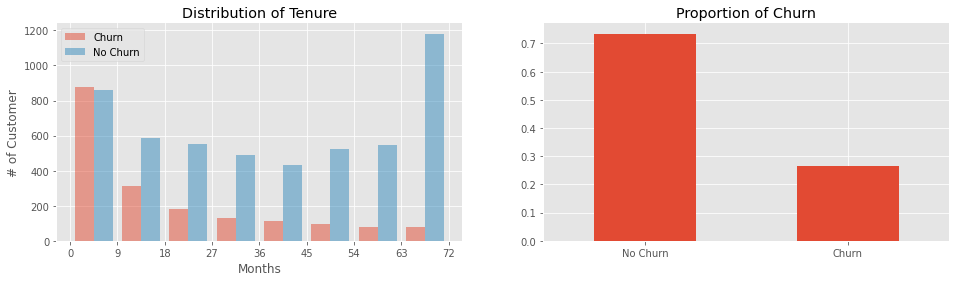

In [558]:
f, ax = plt.subplots(1,2,figsize=(16,4))

_, bins, _ = ax[0].hist([data_x[data_y.astype(bool)],data_x[~data_y.astype(bool)]],label=['Churn','No Churn'],alpha=0.5,bins=8)
ax[0].set_xticks(bins)
ax[0].legend()

data_y.value_counts(normalize=True).plot(kind='bar',ax=ax[1])
ax[1].set_xticklabels(['No Churn','Churn'],rotation=0)

ax[0].spines.top.set_visible(False)
ax[1].spines.top.set_visible(False)
ax[0].spines.right.set_visible(False)
ax[1].spines.right.set_visible(False)

ax[0].set_ylabel('# of Customer')
ax[0].set_xlabel('Months')

ax[0].set_title('Distribution of Tenure')
ax[1].set_title('Proportion of Churn');

In [559]:
kmf = KaplanMeierFitter()
kmf.fit(data_x,data_y)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 7043 total observations, 5174 right-censored observations>

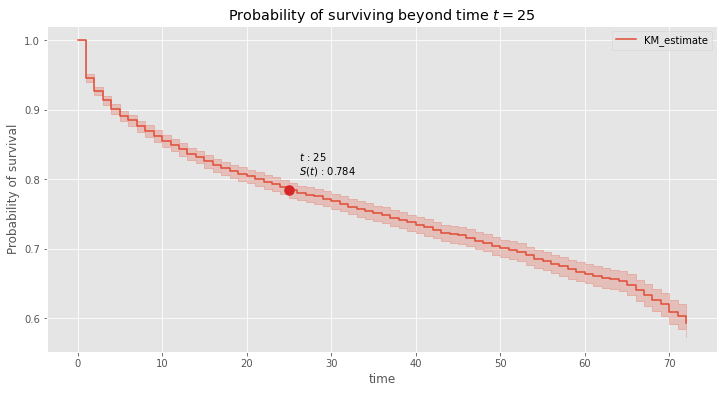

In [560]:
f, ax = plt.subplots(figsize=(12,6))
kmf.plot_survival_function()

day_to_plot = 25
surv_prob = kmf.predict(day_to_plot)

ax.scatter(day_to_plot,surv_prob,s=100,c='tab:red',zorder=100)
ax.text(day_to_plot*1.05,surv_prob*1.03,s=f'$t$ : {day_to_plot} \n$S(t)$ : {round(surv_prob,3)}');
ax.set_ylabel('Probability of survival')
ax.set_xlabel('time')
ax.set_title(f'Probability of surviving beyond time $t = {day_to_plot}$');

Text(0.5, 1.0, 'Senior Citizen Experiment')

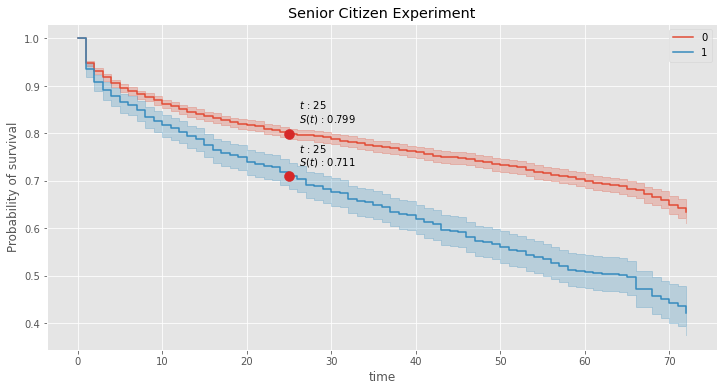

In [561]:
f, ax = plt.subplots(figsize=(12,6))

day_to_plot = 25

for name, group in customer_churn_data.groupby('seniorcitizen'):
    kmf.fit(group.tenure, group.churn, label=name)
    surv_prob = kmf.predict(day_to_plot)
    ax.scatter(day_to_plot,surv_prob,s=100,c='tab:red',zorder=100)
    ax.text(day_to_plot*1.05,surv_prob*1.03,s=f'$t$ : {day_to_plot} \n$S(t)$ : {round(surv_prob,3)}');
    kmf.plot_survival_function()
    
ax.set_ylabel('Probability of survival')
ax.set_xlabel('time')
ax.set_title('Senior Citizen Experiment')

In [562]:
senior_citizen_mask = customer_churn_data.seniorcitizen == 1

model_control = KaplanMeierFitter().fit(customer_churn_data[~senior_citizen_mask].tenure, customer_churn_data[~senior_citizen_mask].churn, label='control')
model_sc = KaplanMeierFitter().fit(customer_churn_data[senior_citizen_mask].tenure, customer_churn_data[senior_citizen_mask].churn, label='senior_citizen')

results = survival_difference_at_fixed_point_in_time_test(25.0, model_control, model_sc)

print(f'p-value        : {round(results.p_value,12)}')
print(f'test statistic : {round(results.test_statistic,3)}')

p-value        : 1.84e-10
test statistic : 40.629


In [563]:
customer_churn_data['dependents'] = customer_churn_data['dependents'].map({'No':0,'Yes':1})
customer_churn_data['partner'] = customer_churn_data['partner'].map({'No':0,'Yes':1})

cph = CoxPHFitter().fit(customer_churn_data,duration_col='tenure',event_col='churn')
cph.print_summary()

/home/nasserboan/miniconda3/lib/python3.9/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -15374.88
         time fit was run = 2022-08-14 04:06:57 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
seniorcitizen   0.47       1.59       0.05             0.36             0.57                 1.43                 1.77
dependents     -0.42       0.66       0.07            -0.56            -0.29                 0.57                 0.75
partner        -0.83       0.44       0.05            -0.94            -0.73                 0.39                 0.48

                cmp to      z      p   -log2(p)
covariate                                      
seniorcitizen     0.00   8.55 <0.005      56.20
dependents        0.00  -6.20 <0.005      30.76
partner           0.00 -15.49 <0.005     177.32
---
Concordance = 0.66
Partial AIC = 30755.77
log-likelihood ratio test = 556.31 on 3 df
-log2(p) of ll-ratio test = 397.06

In [577]:
test = pd.DataFrame([[1,0,0]],columns=['seniorcitizen','dependents','partner'])
cph.predict_cumulative_hazard(test,times=25)

,0
25.0,0.551237
